# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

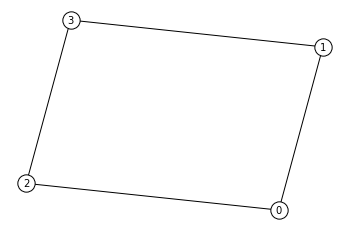

dict_values([2, 2, 2, 2])


{'tag': 'Hamming(2,2)',
 'total_vertices': 4,
 'total_edges': 4,
 'max_edges': 2,
 'adjacency': [[0, 1], [2, 0], [3, 1], [2, 3]],
 'adjacency_hash': '36be59612f3ffd5db5709dc254efe294'}

In [20]:
# Define Adjacency matrix
# Hamming(d,q)
tag = "Hamming(2,2)"
#graph = {(0, 1), (1, 2)}
graph = gt.generate_hamming_graph(2, 2)
penalty = 2

directed = False
qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")

q_min = np.array(list(qubo.values())).min()

gt.get_plot(graph, directed=directed)
plt.show()
graph_params = graph_summary(tag, graph)
graph_params

In [21]:
J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Initial")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges\n")
fact = max([maxJ, maxh/2]) * 1.2
qubo = qubo / fact

J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Rescaled")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

Initial
max(J) = 2.0
max(h) = 5.5
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges

Rescaled
max(J) = 0.6060606060606061
max(h) = 1.6666666666666667
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges


In [22]:
classical_search(qubo)

100%|██████████| 4096/4096 [00:00<00:00, 8937.80it/s]


(-1.818181818181818,
 [(2, 3, 8, 10),
  (1, 3, 6, 10),
  (1, 2, 4, 10),
  (0, 3, 6, 8),
  (0, 2, 4, 8),
  (0, 1, 4, 6)])

In [23]:
# DWave settings
dwave_config = {
    "annealing_time": 200,  # integer microseconds [1, 2000]
    "answer_mode": "raw",
    "auto_scale": False,
    "num_reads": 1000,  # raw will dump out all results
    "num_spin_reversal_transforms": 0,  # ask Travis what this is
    "readout_thermalization": 0, # default 0
    "programming_thermalization": 1000, # default 1000
}
solver = "DW_2000Q_5"

experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, qubo=qubo)

In [ ]:
# Solve on DWave and push to database
sampler = DWaveSampler(solver=solver)
embed = EmbeddingComposite(sampler)
qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
for idx in range(10):
    print(idx)
    result = embed.sample_qubo(qubo_dict, **dwave_config)
    raw = result.to_pandas_dataframe()
    data_params = data_summary(raw, graph_params, experiment_params)
    result = insert_result(graph_params, experiment_params, data_params)
print(raw.sort_values("energy", ascending=True))

0
1
2
3
4
5
6
7
8
